**Loading CEDAR Dataset for training :**

> This project uses the CEDAR dataset for training. The CEDAR dataset contains signatures relating to 55 different signers. There are 24 genuine signatures collected from each signer at regular time intervals and 24 forged signatures for each signer. The following 3 cells are to be executed in Google Collab to load the dataset 'signatures.zip' into the notebook from Google Drive.



In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fid = drive.ListFile({'q':"title='signatures.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('signatures.zip') 

**Importing required packages :**

In [25]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Multiply, Subtract, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, Dropout, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform, he_normal
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
K.set_image_data_format('channels_last') 
K.set_learning_phase(1) 
import scipy
import cv2
from keras.layers import subtract
import keras
from keras.layers import Lambda
import tensorflow as tf 
from keras.optimizers import SGD, RMSprop, Adadelta     

**Network Architecture :** 

> The Siamese network contains 2 sections that run parallel to each other. An image pair is given as input to the model and the task is to find whether the 2 images form a similar pair in case both are images of genuine signatures or a dissimilar pair in case one of the images is genuine and the other is forged.




In [2]:
# Preprocessing input:

def preprocessing_input(X_input):
    scipy.misc.imresize(X_input, (155,220), interp='bilinear')
    X_input=cv2.bitwise_not(X_input)
    X_input=X_input/245
    return X_input  

In [3]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def euclidean_distance_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [4]:
def contrastive_loss(y_true,y_pred):
    margin=1
    L=K.mean((1-y_true) * K.square(y_pred) + (y_true) * K.square(K.maximum(1-y_pred, 0)))
    return L

In [5]:
def sigmodel(input_shape):
    
    seq = Sequential()
    seq.add(Convolution2D(96, 11, 11, activation='relu', name='conv11', subsample=(4, 4), input_shape= input_shape, 
                        init='he_normal'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Convolution2D(256, 5, 5, activation='relu', name='conv21', subsample=(1, 1), init='he_normal'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Convolution2D(384, 3, 3, activation='relu', name='conv31', subsample=(1, 1), init='he_normal'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Convolution2D(256, 3, 3, activation='relu', name='conv32', subsample=(1, 1), init='he_normal'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init=glorot_uniform(seed=0)))
    seq.add(Dropout(0.3))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init=glorot_uniform(seed=0))) 
    
    return seq

In [ ]:
apply_sigmodel = sigmodel((155,220,3))
    
X_input1 = Input(shape=(155,220,3))
X_input2 = Input(shape=(155,220,3)) 

X_vect1 = apply_sigmodel(X_input1)
X_vect2 = apply_sigmodel(X_input2)
    
distance = Lambda(euclidean_distance, output_shape=euclidean_distance_output_shape)([X_vect1,X_vect2])
    
model = Model(input=[X_input1,X_input2], output=distance)    

In [7]:
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)

In [8]:
model.compile(optimizer=rms,loss=contrastive_loss,metrics=['accuracy']) 

**Transferring the dataset into a list for further processing :**


> The uploaded zip file signatures.zip is unzipped. All forged signatures are added to the list forg_list_1 and all genuine signatures are appended to the list org_list_1.


In [ ]:
# opening the zip file in READ mode

from zipfile import ZipFile
file_name='signatures.zip'
forg_list_1=[]
with ZipFile(file_name, 'r') as zf:
    # printing all the contents of the zip file
    #zf.printdir()
    zf.extractall()
    for i in range(55):
        p=[]
        for j in range(24):
            data = zf.read('signatures/full_forg/forgeries_'+str(i+1) +'_' +str(j+1)+'.png')
            img_path = 'signatures/full_forg/forgeries_'+str(i+1) +'_' +str(j+1)+'.png'
            img = image.load_img(img_path,target_size=(155,220)) 
            x = image.img_to_array(img)
            x=preprocessing_input(x)
            p.append(x)
        forg_list_1.append(p)  
    org_list_1=[]        
    for i in range(55):
        p=[]
        for j in range(24):
            data = zf.read('signatures/full_org/original_'+str(i+1) +'_' +str(j+1)+'.png')
            img_path = 'signatures/full_org/original_'+str(i+1) +'_' +str(j+1)+'.png'
            img = image.load_img(img_path, target_size=(155,220)) 
            x = image.img_to_array(img)
            x=preprocessing_input(x)
            p.append(x)
        org_list_1.append(p)                                            


**Making (genuine, genuine) and (genuine, forged) pairs for training :**

> Providing input to our model, we need 2 arrays - X_train1 and X_train2. The corresponding elements of each array form a pair that is used for training. The model input is a list of the form [X_train1, X_train2]. The images are first added to a list which is then converted to an array using np.asarray().




In [0]:
# To make (genuine,genuine) pairs and (genuine,forged) pairs
X_train1=[]
X_train2=[]
for i in range(50):
    count=24
    while(count>1):
        for j in range(0,count-1):
            X_train1.append(org_list_1[i][24-count])
            X_train2.append(org_list_1[i][24-count+j+1])
        count=count-1
        
for i in range(50):
    count=24
    while(count>1):
        for j in range(0,count-1):
            X_train1.append(org_list_1[i][24-count])
            X_train2.append(forg_list_1[i][24-count+j+1])
        count=count-1       

In [0]:
X_train1=np.asarray(X_train1)
X_train2=np.asarray(X_train2)    

**Defining Y_train :**

> The expected prediction for an input of 2 similar samples is y=0 and for 2 dissimilar samples is y=1. For training on this dataset, we create the array Y_train with these values in appropriate postions.



In [0]:
Y_train=np.array([])
for m in range(13800):
    Y_train=np.insert(Y_train,0,1)
for n in range(13800):
    Y_train=np.insert(Y_train,0,0)    

The following 2 blocks have to be executed to allow Collab to access Google Drive. This connection is necessary to allow us to store trained weights in Google Drive or to load the pre-trained weights.

In [ ]:
# To allow colab to access Google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# To allow colab to access Google drive
!mkdir -p drive
!google-drive-ocamlfuse drive

The following block is used to train the network/update the weights according to the specifications. Pre-trained weights can be loaded instead by executing model.load_weights() as seen below.

In [ ]:
model.fit([X_train1,X_train2], Y_train, epochs = 5, batch_size = 10)      

In [0]:
import h5py
model.save_weights('model_weights33.h5')     # Enter file location where weights are to be saved.

In [0]:
del X_train1, X_train2  # Free up memory space.

In [9]:
model.load_weights('my_model3.h5', by_name=False)    # Use this line to load the weights stored earlier.

**Testing model accuracy : **

> To check the model accuracy, we use signatures relating to the last 5 signers from the dataset. These images have not been used for training the model. We make 1380 (genuine,genuine) pairs and 2880 (genuine,forged) pairs and pass it to the model for testing in the same way as we passed inputs for training. Thus the model is tested over 4260 image pairs and has attained a prediction accuracy of 100%

> * Note that the accuracy has been custom defined. If the rounded off prediction value occurs in the range of 0-5, the second signature is considered genuine and if it occurs in the range >5, the second signature is considered to be forged.

In [141]:
count=0
from zipfile import ZipFile
file_name='signatures.zip'
with ZipFile(file_name, 'r') as zf:
    zf.extractall()
    for i in range(51,56):
        for j in range(1,25):
            img_path2 = 'signatures/full_org/original_'+str(i)+'_'+str(j)+'.png'
            img2 = image.load_img(img_path2, target_size=(155,220))
            x2= image.img_to_array(img2)
            x2=preprocessing_input(x2)    

            for k in range(1,25):
                img_path1 = 'signatures/full_forg/forgeries_'+str(i)+'_'+str(k)+'.png'
                img1 = image.load_img(img_path1, target_size=(155,220))
                x1= image.img_to_array(img1)
                x1=preprocessing_input(x1) 

                l1=[x1]
                l2=[x2]
                l1=np.asarray(l1)
                l2=np.asarray(l2)
                res=np.round(model.predict([l1,l2]))
                if(res[0][0]>=5):
                    count=count+1  

            for m in range(j+1,25):
                img_path3 = 'signatures/full_org/original_'+str(i)+'_'+str(k)+'.png'
                img3 = image.load_img(img_path3, target_size=(155,220))
                x3= image.img_to_array(img3)
                x3=preprocessing_input(x3)           
                l3=[x3]
                l2=[x2]
                l3=np.asarray(l3)
                l2=np.asarray(l2)
                res=np.round(model.predict([l3,l2]))
                if(res[0][0]<=5):
                    count=count+1
          
print('Test Accuracy = '+str(count/4260))                   

Test Accuracy = 1.0


# **Demonstration example : **

In [26]:
from zipfile import ZipFile
file_name='signatures.zip'
with ZipFile(file_name, 'r') as zf:
    zf.extractall()
    img_path1 = 'signatures/full_org/original_55_9.png'
    img_path2 = 'signatures/full_org/original_55_17.png'
    img_path3 = 'signatures/full_forg/forgeries_55_10.png'
    img1 = image.load_img(img_path1, target_size=(155,220))
    img2 = image.load_img(img_path2, target_size=(155,220))
    img3 = image.load_img(img_path3, target_size=(155,220))
    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)
    x3 = image.img_to_array(img3)
    x1=preprocessing_input(x1)
    x2=preprocessing_input(x2)
    x3=preprocessing_input(x3)   

 **Original signature sample : **
 
 Remaining signature samples are compared against this one.

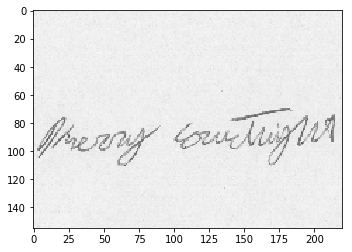

In [30]:
imshow(img1)

** The test signature samples : **

It is known that the first sample is genuine and the second is forged. We wish to receive the same as prediction from our model

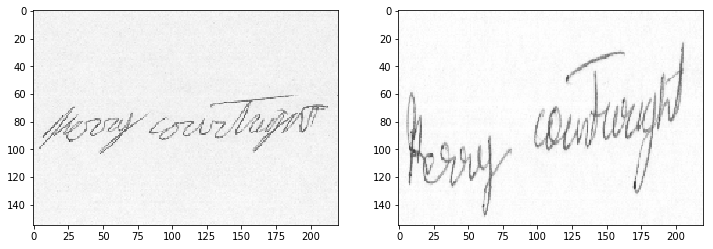

In [33]:
fig=plt.figure(figsize=(12,12))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(img2)
fig.add_subplot(rows, columns, 2)
plt.imshow(img3)
plt.show()       

In [18]:
l1=[x1]
l2=[x2]
l3=[x3]
l1=np.asarray(l1)
l2=np.asarray(l2)
l3=np.asarray(l3)
t1=model.predict([l1,l2])
t2=model.predict([l2,l3])
y1=(np.round(model.predict([l1,l2])))
y2=(np.round(model.predict([l2,l3])))  

if (y1[0][0] == 0):
  print('The second signature is genuine \n')
elif(y1[0][0]>=1):
  print('The second signature is forged \n')
if (y2[0][0] == 0):
  print('The third siganture is genuine \n')
elif(y2[0][0]>=1):
  print('The third signature is forged \n')

print('t1='+str(t1))
print('t2='+str(t2))

The second signature is genuine 

The third signature is forged 

t1=[[ 0.06032007]]
t2=[[ 6.98319483]]


# Front-end Application Model

Execute the cell below and enter values as required



Details for original signature :

Enter signer number.(Should be a number from 1 to 55) : 52
Enter signature number for signer number. 52(Should be a number from 1 to 24) : 16

Details for test signature sample : 

Enter forg for forged and org for genuine signature : forg
Enter signature number for signer number 52(Should be a number from 1 to 24) : 21

Prediction value = [[ 9.5518465]]
The Prediction value being in the range of 0-5 means the signature is probably genuine and greater than 5 means the sigature is probably forged 

The signature sample is forged. 



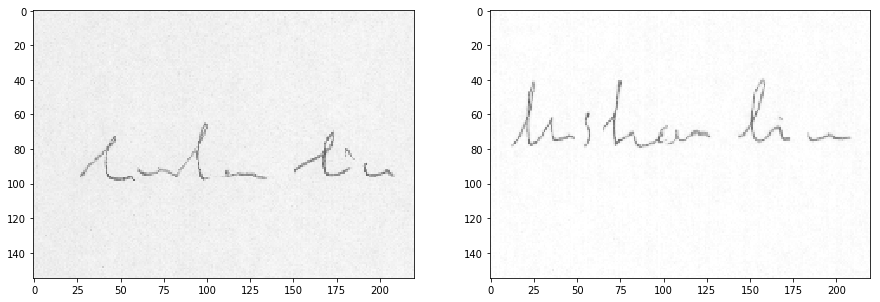

In [24]:
print('Details for original signature :\n')
signer=input('Enter signer number.(Should be a number from 1 to 55) : ')
sign1=input('Enter signature number for signer number '+signer+'(.Should be a number from 1 to 24) : ')

print('\nDetails for test signature sample : \n')
type=input('Enter forg for forged and org for genuine signature : ')

sign2=input('Enter signature number for signer number '+signer+'(.Should be a number from 1 to 24) : ') 
if(type=='forg'):
  st='forgeries'
elif(type=='org'):
  st='original'
from zipfile import ZipFile
file_name='signatures.zip'
with ZipFile(file_name, 'r') as zf:
    zf.extractall()
    img_path1 = 'signatures/full_org/original_'+signer+'_'+sign1+'.png'
    img_path2 = 'signatures/full_'+type+'/'+st+'_'+signer+'_'+sign2+'.png'   
    img1 = image.load_img(img_path1, target_size=(155,220))
    img2 = image.load_img(img_path2, target_size=(155,220))

    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    x1=preprocessing_input(x1)
    x2=preprocessing_input(x2)
    
    l1=[x1]
    l2=[x2]
    l1=np.asarray(l1)
    l2=np.asarray(l2)
    nom=model.predict([l1,l2])
    res=np.round(model.predict([l1,l2]))
    print('\nPrediction value = '+str(nom))
    print('The Prediction value being close to 0 means the signature is probably genuine and greater than 5 means the sigature is probably forged \n')
    if(res[0][0] >= 1):
        print('The signature sample is forged. \n')
    if (res[0][0] ==0):
          print('The signature sample is genuine. \n')
            

fig=plt.figure(figsize=(15,15))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(img1)
fig.add_subplot(rows, columns, 2)
plt.imshow(img2)
plt.show()       